In [1]:
### based on https://github.com/kylemcdonald/Parametric-t-SNE/blob/master/Parametric%20t-SNE%20(Keras).ipynb

In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy

### MNIST

In [7]:
dataset = 'mnist'
dims = (28,28,1)

##### load dataset

In [8]:
from tensorflow.keras.datasets import mnist

# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images / 255.0).astype("float32")
X_test = (test_images / 255.0).astype("float32")
X_train = np.expand_dims(X_train, -1)#((len(X_train), np.product(np.shape(X_train)[1:])))
#X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
#X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat = X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
X_test = X_test.reshape((10000, 28, 28, 1))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


In [9]:
X_train.shape

(50000, 28, 28, 1)

### Compute Probability in X

$$
p_{j \mid i}=\frac{\exp \left(-\left\|x_{i}-x_{j}\right\|^{2} / 2 \sigma_{i}^{2}\right)}{\sum_{k \neq i} \exp \left(-\left\|x_{i}-x_{k}\right\|^{2} / 2 \sigma_{i}^{2}\right)}
$$

$$
p_{i j}=\frac{p_{j \mid i}+p_{i \mid j}}{2 n}
$$

In [10]:
def Hbeta(D, beta):
    """Computes the Gaussian kernel values given a vector of
    squared Euclidean distances, and the precision of the Gaussian kernel.
    The function also computes the perplexity (P) of the distribution."""
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(np.multiply(D, P)) / sumP
    P = P / sumP
    return H, P

In [11]:
def x2p(X, u=15, tol=1e-4, print_iter=500, max_tries=50, verbose=0):
    """
    % X2P Identifies appropriate sigma's to get kk NNs up to some tolerance 
    %
    %   [P, beta] = x2p(xx, kk, tol)
    % 
    % Identifies the required precision (= 1 / variance^2) to obtain a Gaussian
    % kernel with a certain uncertainty for every datapoint. The desired
    % uncertainty can be specified through the perplexity u (default = 15). The
    % desired perplexity is obtained up to some tolerance that can be specified
    % by tol (default = 1e-4).
    % The function returns the final Gaussian kernel in P, as well as the 
    % employed precisions per instance in beta.
    %
    """
    
    # Initialize some variables
    n = X.shape[0]  # number of instances
    P = np.zeros((n, n))  # empty probability matrix
    beta = np.ones(n)  # empty precision vector
    logU = np.log(u)  # log of perplexity (= entropy)

    # Compute pairwise distances
    if verbose > 0:
        print("Computing pairwise distances...")
    sum_X = np.sum(np.square(X), axis=1)
    # note: translating sum_X' from matlab to numpy means using reshape to add a dimension
    D = sum_X + sum_X[:, None] + -2 * X.dot(X.T)

    # Run over all datapoints
    if verbose > 0:
        print("Computing P-values...")
    for i in range(n):
        if verbose > 1 and print_iter and i % print_iter == 0:
            print("Computed P-values {} of {} datapoints...".format(i, n))

        # Set minimum and maximum values for precision
        betamin = float("-inf")
        betamax = float("+inf")

        # Compute the Gaussian kernel and entropy for the current precision
        indices = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
        Di = D[i, indices]
        H, thisP = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i]
                if np.isinf(betamax):
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i]
                if np.isinf(betamin):
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, indices] = thisP

    if verbose > 0:
        print("Mean value of sigma: {}".format(np.mean(np.sqrt(1 / beta))))
        print("Minimum value of sigma: {}".format(np.min(np.sqrt(1 / beta))))
        print("Maximum value of sigma: {}".format(np.max(np.sqrt(1 / beta))))

    return P, beta

In [12]:
def compute_joint_probabilities(
    samples, batch_size=5000, d=2, perplexity=30, tol=1e-5, verbose=0
):
    """ This function computes the probababilities in X, split up into batches
    % Gaussians employed in the high-dimensional space have the specified
    % perplexity (default = 30). The number of degrees of freedom of the
    % Student-t distribution may be specified through v (default = d - 1).
    """
    v = d - 1

    # Initialize some variables
    n = samples.shape[0]
    batch_size = min(batch_size, n)

    # Precompute joint probabilities for all batches
    if verbose > 0:
        print("Precomputing P-values...")
    batch_count = int(n / batch_size)
    P = np.zeros((batch_count, batch_size, batch_size))
    # for each batch of data
    for i, start in enumerate(tqdm(range(0, n - batch_size + 1, batch_size))):
        # select batch
        curX = samples[start : start + batch_size]  
        # compute affinities using fixed perplexity
        P[i], _ = x2p(
            curX, perplexity, tol, verbose=verbose
        )  
        # make sure we don't have NaN's
        P[i][np.isnan(P[i])] = 0  
        # make symmetric
        P[i] = P[i] + P[i].T  # / 2
        # obtain estimation of joint probabilities                             
        P[i] = P[i] / P[i].sum()  
        P[i] = np.maximum(P[i], np.finfo(P[i].dtype).eps)

    return P

In [13]:
batch_size = 5000

In [14]:
%time  P = compute_joint_probabilities(X_train_flat, batch_size=batch_size, perplexity=30, verbose=2)

Precomputing P-values...


Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-values 3500 of 5000 datapoints...
Computed P-values 4000 of 5000 datapoints...
Computed P-values 4500 of 5000 datapoints...
Mean value of sigma: 2.210395926597027
Minimum value of sigma: 1.1465189822400297
Maximum value of sigma: 3.423562241637291
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 5000 datapoints...
Computed P-values 500 of 5000 datapoints...
Computed P-values 1000 of 5000 datapoints...
Computed P-values 1500 of 5000 datapoints...
Computed P-values 2000 of 5000 datapoints...
Computed P-values 2500 of 5000 datapoints...
Computed P-values 3000 of 5000 datapoints...
Computed P-

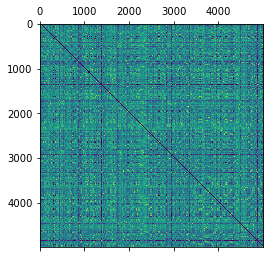

In [15]:
plt.matshow(np.log(P[0]))

In [16]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [17]:
#np.save(DATA_DIR/'P.npy', P)

### Compute probability in embedding

$$
q_{i j}=\frac{\left(1+\left\|f\left(x_{i} \mid W\right)-f\left(x_{j} \mid W\right)\right\|^{2} / \alpha\right)^{-\frac{\alpha+1}{2}}}{\sum_{k \neq l}\left(1+\left\|f\left(x_{k} \mid W\right)-f\left(x_{l} \mid W\right)\right\|^{2} / \alpha\right)^{-\frac{\alpha+1}{2}}}
$$

In [18]:
d = 2 # latent dimensions
v = d - 1.0 # this is alpha in the paper, where alpha should be d - 1

In [19]:
def z2p(z, n, eps = 10e-15): 
    """ Computes the low dimensional probability
    """
    sum_act = tf.math.reduce_sum(tf.math.square(z), axis=1)
    Q = K.reshape(sum_act, [-1, 1]) + -2 * tf.keras.backend.dot(
        z, tf.transpose(z)
    )
    Q = (sum_act + Q) / v
    Q = tf.math.pow(1 + Q, -(v + 1) / 2)
    Q *= 1 - np.eye(n)
    Q /= tf.math.reduce_sum(Q)
    Q = tf.math.maximum(Q, eps)
    return Q

$$
C=K L(P \| Q)=\sum_{i \neq j} p_{i j} \log \frac{p_{i j}}{q_{i j}}
$$

In [20]:
def tsne_loss(d, batch_size, eps= 10e-15):
    #v = d - 1.0
    def loss(P, Z):
        """
        P is the joint probabilities for this batch (Keras loss functions call this y_true)
        Z is the low-dimensional output (Keras loss functions call this y_pred)
        """
        Q = z2p(Z, n = batch_size, eps = eps)
        return tf.math.reduce_sum(P * tf.math.log((P + eps) / (Q + eps)))
    return loss

### Train model

In [21]:
n_components = 2

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

In [23]:
opt = tf.keras.optimizers.Adam(lr=0.01)

In [24]:
model.compile(loss=tsne_loss(d=n_components, batch_size=batch_size), optimizer=opt)

In [25]:
# Joint probabilities of data
Y_train_tsne = P.reshape(X_train.shape[0], -1)

In [26]:
Y_train_tsne.shape

(50000, 5000)

In [27]:
# because shuffle == False, the same batches are used each time...
history = model.fit(X_train, Y_train_tsne, batch_size=batch_size, shuffle=False, nb_epoch=10000)

W0719 23:52:36.935626 140227513493312 training.py:792] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 50000 samples
Epoch 1/10000
50000/50000 [==============================] - 10s 209us/sample - loss: 3.8420
Epoch 2/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 3.1591
Epoch 3/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.8558
Epoch 4/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.6445
Epoch 5/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.5020
Epoch 6/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.4049
Epoch 7/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 2.3376
Epoch 8/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 2.2897
Epoch 9/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 2.2570
Epoch 10/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 2.2285
Epoch 11/10000
50000/50000 [==============================] - 1s

50000/50000 [==============================] - 1s 17us/sample - loss: 1.7496
Epoch 90/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.7445
Epoch 91/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.7485
Epoch 92/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.7535
Epoch 93/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.7604
Epoch 94/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.7564
Epoch 95/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.7534
Epoch 96/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.7358
Epoch 97/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.7213
Epoch 98/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.7237
Epoch 99/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.7278
Epo

50000/50000 [==============================] - 1s 16us/sample - loss: 1.6149
Epoch 178/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6120
Epoch 179/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6114
Epoch 180/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.6132
Epoch 181/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6089
Epoch 182/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6062
Epoch 183/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6115
Epoch 184/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6115
Epoch 185/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.6047
Epoch 186/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.6092
Epoch 187/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 

50000/50000 [==============================] - 1s 16us/sample - loss: 1.5608
Epoch 266/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5617
Epoch 267/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.5620
Epoch 268/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5626
Epoch 269/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5591
Epoch 270/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.5640
Epoch 271/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.5658
Epoch 272/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.5711
Epoch 273/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.5603
Epoch 274/10000
50000/50000 [==============================] - 1s 19us/sample - loss: 1.5596
Epoch 275/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 

50000/50000 [==============================] - 1s 16us/sample - loss: 1.5308
Epoch 354/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.5267
Epoch 355/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.5247
Epoch 356/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5190
Epoch 357/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5168
Epoch 358/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.5197
Epoch 359/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5197
Epoch 360/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.5132
Epoch 361/10000
50000/50000 [==============================] - 1s 19us/sample - loss: 1.5134
Epoch 362/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.5086
Epoch 363/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 

50000/50000 [==============================] - 1s 16us/sample - loss: 1.4857
Epoch 442/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4903
Epoch 443/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4944
Epoch 444/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4922
Epoch 445/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4906
Epoch 446/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4906
Epoch 447/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4861
Epoch 448/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4839
Epoch 449/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4806
Epoch 450/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4792
Epoch 451/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 

50000/50000 [==============================] - 1s 16us/sample - loss: 1.4802
Epoch 530/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4833
Epoch 531/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4854
Epoch 532/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4882
Epoch 533/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4882
Epoch 534/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4904
Epoch 535/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4886
Epoch 536/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4923
Epoch 537/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4949
Epoch 538/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4980
Epoch 539/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 

50000/50000 [==============================] - 1s 17us/sample - loss: 1.4681
Epoch 618/10000
50000/50000 [==============================] - 1s 19us/sample - loss: 1.4708
Epoch 619/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4684
Epoch 620/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.4682
Epoch 621/10000
50000/50000 [==============================] - 1s 19us/sample - loss: 1.4666
Epoch 622/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4632
Epoch 623/10000
50000/50000 [==============================] - 1s 19us/sample - loss: 1.4632
Epoch 624/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.4609
Epoch 625/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4600
Epoch 626/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4617
Epoch 627/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4551
Epoch 706/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4553
Epoch 707/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4575
Epoch 708/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4587
Epoch 709/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4616
Epoch 710/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4655
Epoch 711/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4653
Epoch 712/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.4683
Epoch 713/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4615
Epoch 714/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.4615
Epoch 715/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4628
Epoch 794/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4565
Epoch 795/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4558
Epoch 796/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4529
Epoch 797/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4487
Epoch 798/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4438
Epoch 799/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4431
Epoch 800/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4398
Epoch 801/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4412
Epoch 802/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4417
Epoch 803/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4421
Epoch 882/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4446
Epoch 883/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4501
Epoch 884/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4527
Epoch 885/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4528
Epoch 886/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4544
Epoch 887/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4509
Epoch 888/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4495
Epoch 889/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4494
Epoch 890/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4478
Epoch 891/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 

50000/50000 [==============================] - 1s 17us/sample - loss: 1.4405
Epoch 970/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4399
Epoch 971/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4403
Epoch 972/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4401
Epoch 973/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4425
Epoch 974/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4440
Epoch 975/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4434
Epoch 976/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4416
Epoch 977/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4421
Epoch 978/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4393
Epoch 979/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4391
Epoch 1057/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4399
Epoch 1058/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4384
Epoch 1059/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4353
Epoch 1060/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4358
Epoch 1061/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4339
Epoch 1062/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4340
Epoch 1063/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4314
Epoch 1064/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4319
Epoch 1065/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4288
Epoch 1066/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4298
Epoch 1144/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4284
Epoch 1145/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4285
Epoch 1146/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4284
Epoch 1147/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4271
Epoch 1148/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4288
Epoch 1149/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4305
Epoch 1150/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4310
Epoch 1151/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4308
Epoch 1152/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4298
Epoch 1153/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 18us/sample - loss: 1.4189
Epoch 1231/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4167
Epoch 1232/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4187
Epoch 1233/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4186
Epoch 1234/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4202
Epoch 1235/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4216
Epoch 1236/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4236
Epoch 1237/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4226
Epoch 1238/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4260
Epoch 1239/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4266
Epoch 1240/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.4318
Epoch 1318/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4299
Epoch 1319/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4308
Epoch 1320/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4292
Epoch 1321/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4239
Epoch 1322/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4215
Epoch 1323/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4192
Epoch 1324/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4170
Epoch 1325/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4191
Epoch 1326/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4199
Epoch 1327/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4217
Epoch 1405/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4218
Epoch 1406/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4233
Epoch 1407/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4211
Epoch 1408/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4234
Epoch 1409/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4205
Epoch 1410/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4171
Epoch 1411/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4164
Epoch 1412/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4187
Epoch 1413/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4194
Epoch 1414/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 17us/sample - loss: 1.4236
Epoch 1492/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4275
Epoch 1493/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4292
Epoch 1494/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4297
Epoch 1495/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4256
Epoch 1496/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4237
Epoch 1497/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4227
Epoch 1498/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4205
Epoch 1499/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4158
Epoch 1500/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4151
Epoch 1501/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.4132
Epoch 1579/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4110
Epoch 1580/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4149
Epoch 1581/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4172
Epoch 1582/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4211
Epoch 1583/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4223
Epoch 1584/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4248
Epoch 1585/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4250
Epoch 1586/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4235
Epoch 1587/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4185
Epoch 1588/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.4025
Epoch 1666/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4042
Epoch 1667/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4051
Epoch 1668/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4041
Epoch 1669/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4073
Epoch 1670/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4103
Epoch 1671/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4102
Epoch 1672/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4133
Epoch 1673/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4138
Epoch 1674/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4137
Epoch 1675/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4193
Epoch 1753/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4239
Epoch 1754/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4208
Epoch 1755/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4207
Epoch 1756/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4190
Epoch 1757/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4182
Epoch 1758/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4153
Epoch 1759/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4140
Epoch 1760/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4093
Epoch 1761/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4055
Epoch 1762/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4166
Epoch 1840/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4114
Epoch 1841/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4057
Epoch 1842/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4074
Epoch 1843/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4076
Epoch 1844/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4068
Epoch 1845/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4067
Epoch 1846/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4076
Epoch 1847/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4069
Epoch 1848/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4064
Epoch 1849/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4093
Epoch 1927/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4100
Epoch 1928/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4108
Epoch 1929/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4115
Epoch 1930/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4121
Epoch 1931/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4092
Epoch 1932/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4066
Epoch 1933/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4055
Epoch 1934/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4067
Epoch 1935/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4075
Epoch 1936/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.4038
Epoch 2014/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4041
Epoch 2015/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4070
Epoch 2016/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4095
Epoch 2017/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4093
Epoch 2018/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4141
Epoch 2019/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4108
Epoch 2020/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4089
Epoch 2021/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4085
Epoch 2022/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4072
Epoch 2023/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4096
Epoch 2101/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4081
Epoch 2102/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4055
Epoch 2103/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4041
Epoch 2104/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4044
Epoch 2105/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4067
Epoch 2106/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4050
Epoch 2107/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4046
Epoch 2108/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4028
Epoch 2109/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4049
Epoch 2110/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.4034
Epoch 2188/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4034
Epoch 2189/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4055
Epoch 2190/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4056
Epoch 2191/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4011
Epoch 2192/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4046
Epoch 2193/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3986
Epoch 2194/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3962
Epoch 2195/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3962
Epoch 2196/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3969
Epoch 2197/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.4028
Epoch 2275/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4050
Epoch 2276/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4056
Epoch 2277/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4058
Epoch 2278/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4059
Epoch 2279/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4029
Epoch 2280/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4012
Epoch 2281/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3994
Epoch 2282/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3978
Epoch 2283/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3984
Epoch 2284/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3988
Epoch 2362/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4026
Epoch 2363/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4027
Epoch 2364/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4063
Epoch 2365/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4068
Epoch 2366/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4057
Epoch 2367/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4049
Epoch 2368/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4058
Epoch 2369/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4076
Epoch 2370/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.4096
Epoch 2371/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3978
Epoch 2449/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4007
Epoch 2450/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4000
Epoch 2451/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4019
Epoch 2452/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4015
Epoch 2453/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4016
Epoch 2454/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4011
Epoch 2455/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3999
Epoch 2456/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3976
Epoch 2457/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3952
Epoch 2458/10000
50000/50000 [==============================] - 1s 17us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3958
Epoch 2536/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3979
Epoch 2537/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3956
Epoch 2538/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3984
Epoch 2539/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3989
Epoch 2540/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3970
Epoch 2541/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3952
Epoch 2542/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3914
Epoch 2543/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3899
Epoch 2544/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3884
Epoch 2545/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.4073
Epoch 2623/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4090
Epoch 2624/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4069
Epoch 2625/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4074
Epoch 2626/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4041
Epoch 2627/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4002
Epoch 2628/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3970
Epoch 2629/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3972
Epoch 2630/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3971
Epoch 2631/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3947
Epoch 2632/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3953
Epoch 2710/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3947
Epoch 2711/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3948
Epoch 2712/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3952
Epoch 2713/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3958
Epoch 2714/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3982
Epoch 2715/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3982
Epoch 2716/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3949
Epoch 2717/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3968
Epoch 2718/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3970
Epoch 2719/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3876
Epoch 2797/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3887
Epoch 2798/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3896
Epoch 2799/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3903
Epoch 2800/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3897
Epoch 2801/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3884
Epoch 2802/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3857
Epoch 2803/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3854
Epoch 2804/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3837
Epoch 2805/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3837
Epoch 2806/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 17us/sample - loss: 1.3985
Epoch 2884/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3918
Epoch 2885/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3892
Epoch 2886/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3880
Epoch 2887/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3871
Epoch 2888/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3872
Epoch 2889/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3869
Epoch 2890/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3887
Epoch 2891/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3907
Epoch 2892/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3919
Epoch 2893/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3863
Epoch 2971/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3881
Epoch 2972/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3930
Epoch 2973/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3951
Epoch 2974/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3948
Epoch 2975/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3948
Epoch 2976/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3933
Epoch 2977/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3953
Epoch 2978/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3914
Epoch 2979/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3907
Epoch 2980/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 14us/sample - loss: 1.3939
Epoch 3058/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3973
Epoch 3059/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3979
Epoch 3060/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3923
Epoch 3061/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3868
Epoch 3062/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3850
Epoch 3063/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3836
Epoch 3064/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3848
Epoch 3065/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3867
Epoch 3066/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3909
Epoch 3067/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3916
Epoch 3145/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3937
Epoch 3146/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3950
Epoch 3147/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3932
Epoch 3148/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3933
Epoch 3149/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3900
Epoch 3150/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3880
Epoch 3151/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3861
Epoch 3152/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3832
Epoch 3153/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3839
Epoch 3154/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3863
Epoch 3232/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3852
Epoch 3233/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3843
Epoch 3234/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3842
Epoch 3235/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3862
Epoch 3236/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3876
Epoch 3237/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3872
Epoch 3238/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3882
Epoch 3239/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3868
Epoch 3240/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3856
Epoch 3241/10000
50000/50000 [==============================] - 1s 17us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3874
Epoch 3319/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3873
Epoch 3320/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3870
Epoch 3321/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3870
Epoch 3322/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3850
Epoch 3323/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3845
Epoch 3324/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3828
Epoch 3325/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3840
Epoch 3326/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3842
Epoch 3327/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3841
Epoch 3328/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3885
Epoch 3406/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3856
Epoch 3407/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3849
Epoch 3408/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3842
Epoch 3409/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3865
Epoch 3410/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3849
Epoch 3411/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3862
Epoch 3412/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3859
Epoch 3413/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3866
Epoch 3414/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3873
Epoch 3415/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3905
Epoch 3493/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3891
Epoch 3494/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3865
Epoch 3495/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3847
Epoch 3496/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3832
Epoch 3497/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3825
Epoch 3498/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3815
Epoch 3499/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3831
Epoch 3500/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3827
Epoch 3501/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3853
Epoch 3502/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3870
Epoch 3580/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3860
Epoch 3581/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3843
Epoch 3582/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3846
Epoch 3583/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3840
Epoch 3584/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3820
Epoch 3585/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3811
Epoch 3586/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3799
Epoch 3587/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3824
Epoch 3588/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3816
Epoch 3589/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3878
Epoch 3667/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3868
Epoch 3668/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3871
Epoch 3669/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3883
Epoch 3670/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3883
Epoch 3671/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3895
Epoch 3672/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3918
Epoch 3673/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3933
Epoch 3674/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3930
Epoch 3675/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3909
Epoch 3676/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3846
Epoch 3754/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3816
Epoch 3755/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3825
Epoch 3756/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3826
Epoch 3757/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3843
Epoch 3758/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3805
Epoch 3759/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3817
Epoch 3760/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3862
Epoch 3761/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3859
Epoch 3762/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3824
Epoch 3763/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3771
Epoch 3841/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3770
Epoch 3842/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3789
Epoch 3843/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3806
Epoch 3844/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3836
Epoch 3845/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3872
Epoch 3846/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3852
Epoch 3847/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3878
Epoch 3848/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3885
Epoch 3849/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3888
Epoch 3850/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3781
Epoch 3928/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.3805
Epoch 3929/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3798
Epoch 3930/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3800
Epoch 3931/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3795
Epoch 3932/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3807
Epoch 3933/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3793
Epoch 3934/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3777
Epoch 3935/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3773
Epoch 3936/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3789
Epoch 3937/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3807
Epoch 4015/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3825
Epoch 4016/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3858
Epoch 4017/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3885
Epoch 4018/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3909
Epoch 4019/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3918
Epoch 4020/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3962
Epoch 4021/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3996
Epoch 4022/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.4018
Epoch 4023/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3994
Epoch 4024/10000
50000/50000 [==============================] - 1s 14us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3827
Epoch 4102/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3841
Epoch 4103/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3840
Epoch 4104/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3832
Epoch 4105/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3795
Epoch 4106/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3802
Epoch 4107/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3784
Epoch 4108/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3794
Epoch 4109/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3809
Epoch 4110/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3801
Epoch 4111/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3799
Epoch 4189/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3795
Epoch 4190/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3790
Epoch 4191/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3789
Epoch 4192/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3783
Epoch 4193/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3790
Epoch 4194/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3800
Epoch 4195/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3798
Epoch 4196/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3801
Epoch 4197/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3793
Epoch 4198/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3807
Epoch 4276/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3805
Epoch 4277/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3829
Epoch 4278/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3807
Epoch 4279/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3844
Epoch 4280/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3858
Epoch 4281/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3868
Epoch 4282/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3860
Epoch 4283/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3882
Epoch 4284/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3853
Epoch 4285/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3766
Epoch 4363/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3758
Epoch 4364/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3738
Epoch 4365/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3760
Epoch 4366/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3771
Epoch 4367/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3764
Epoch 4368/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3784
Epoch 4369/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3787
Epoch 4370/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3801
Epoch 4371/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3807
Epoch 4372/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3870
Epoch 4450/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3876
Epoch 4451/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3848
Epoch 4452/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3849
Epoch 4453/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3826
Epoch 4454/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3822
Epoch 4455/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3789
Epoch 4456/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3767
Epoch 4457/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3756
Epoch 4458/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3759
Epoch 4459/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3738
Epoch 4537/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3740
Epoch 4538/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3766
Epoch 4539/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3781
Epoch 4540/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3800
Epoch 4541/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3837
Epoch 4542/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3836
Epoch 4543/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3865
Epoch 4544/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3842
Epoch 4545/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3854
Epoch 4546/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3757
Epoch 4624/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3748
Epoch 4625/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3726
Epoch 4626/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3734
Epoch 4627/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3735
Epoch 4628/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3748
Epoch 4629/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3738
Epoch 4630/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3721
Epoch 4631/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3698
Epoch 4632/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3685
Epoch 4633/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3800
Epoch 4711/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3775
Epoch 4712/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3745
Epoch 4713/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3747
Epoch 4714/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3758
Epoch 4715/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3768
Epoch 4716/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3784
Epoch 4717/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3804
Epoch 4718/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3806
Epoch 4719/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3781
Epoch 4720/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3715
Epoch 4798/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3694
Epoch 4799/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3698
Epoch 4800/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3701
Epoch 4801/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3711
Epoch 4802/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3734
Epoch 4803/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3756
Epoch 4804/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3765
Epoch 4805/10000
50000/50000 [==============================] - 1s 19us/sample - loss: 1.3745
Epoch 4806/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3748
Epoch 4807/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3773
Epoch 4885/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3764
Epoch 4886/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3752
Epoch 4887/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3729
Epoch 4888/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3738
Epoch 4889/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3747
Epoch 4890/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3754
Epoch 4891/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3768
Epoch 4892/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3738
Epoch 4893/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3734
Epoch 4894/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3743
Epoch 4972/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3736
Epoch 4973/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3741
Epoch 4974/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3714
Epoch 4975/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3715
Epoch 4976/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3699
Epoch 4977/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3708
Epoch 4978/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3721
Epoch 4979/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3734
Epoch 4980/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3731
Epoch 4981/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3850
Epoch 5059/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.3824
Epoch 5060/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3814
Epoch 5061/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.3764
Epoch 5062/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3754
Epoch 5063/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3753
Epoch 5064/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3755
Epoch 5065/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3773
Epoch 5066/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3797
Epoch 5067/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3847
Epoch 5068/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 17us/sample - loss: 1.3682
Epoch 5146/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3659
Epoch 5147/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3645
Epoch 5148/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3639
Epoch 5149/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3636
Epoch 5150/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3654
Epoch 5151/10000
50000/50000 [==============================] - 1s 18us/sample - loss: 1.3648
Epoch 5152/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3661
Epoch 5153/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3680
Epoch 5154/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3667
Epoch 5155/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3730
Epoch 5233/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3725
Epoch 5234/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3698
Epoch 5235/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3707
Epoch 5236/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3705
Epoch 5237/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3721
Epoch 5238/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3737
Epoch 5239/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3750
Epoch 5240/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3789
Epoch 5241/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3830
Epoch 5242/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3752
Epoch 5320/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3732
Epoch 5321/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3696
Epoch 5322/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3677
Epoch 5323/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3650
Epoch 5324/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3630
Epoch 5325/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3627
Epoch 5326/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3622
Epoch 5327/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3649
Epoch 5328/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3646
Epoch 5329/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3846
Epoch 5407/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3864
Epoch 5408/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3887
Epoch 5409/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3879
Epoch 5410/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3884
Epoch 5411/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3848
Epoch 5412/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3809
Epoch 5413/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3792
Epoch 5414/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3791
Epoch 5415/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3797
Epoch 5416/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3681
Epoch 5494/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3680
Epoch 5495/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3666
Epoch 5496/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3673
Epoch 5497/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3693
Epoch 5498/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3686
Epoch 5499/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3723
Epoch 5500/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3731
Epoch 5501/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3756
Epoch 5502/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3751
Epoch 5503/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3664
Epoch 5581/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3680
Epoch 5582/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3676
Epoch 5583/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3690
Epoch 5584/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3685
Epoch 5585/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3697
Epoch 5586/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3694
Epoch 5587/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3697
Epoch 5588/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3722
Epoch 5589/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3713
Epoch 5590/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 17us/sample - loss: 1.3709
Epoch 5668/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3697
Epoch 5669/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3692
Epoch 5670/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3701
Epoch 5671/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3694
Epoch 5672/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3703
Epoch 5673/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3705
Epoch 5674/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3698
Epoch 5675/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3687
Epoch 5676/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3696
Epoch 5677/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3750
Epoch 5755/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3764
Epoch 5756/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3764
Epoch 5757/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3744
Epoch 5758/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3716
Epoch 5759/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3707
Epoch 5760/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3715
Epoch 5761/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3695
Epoch 5762/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3698
Epoch 5763/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3687
Epoch 5764/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3707
Epoch 5842/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3688
Epoch 5843/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3692
Epoch 5844/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3681
Epoch 5845/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3690
Epoch 5846/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3677
Epoch 5847/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3653
Epoch 5848/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3643
Epoch 5849/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3643
Epoch 5850/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3657
Epoch 5851/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3717
Epoch 5929/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3704
Epoch 5930/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3704
Epoch 5931/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3715
Epoch 5932/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3721
Epoch 5933/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3710
Epoch 5934/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3727
Epoch 5935/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3720
Epoch 5936/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3745
Epoch 5937/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3759
Epoch 5938/10000
50000/50000 [==============================] - 1s 17us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3666
Epoch 6016/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3659
Epoch 6017/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3635
Epoch 6018/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3612
Epoch 6019/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3613
Epoch 6020/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3612
Epoch 6021/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3601
Epoch 6022/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3603
Epoch 6023/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3609
Epoch 6024/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3623
Epoch 6025/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3686
Epoch 6103/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3691
Epoch 6104/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3696
Epoch 6105/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3658
Epoch 6106/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3658
Epoch 6107/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3637
Epoch 6108/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3653
Epoch 6109/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3638
Epoch 6110/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3670
Epoch 6111/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3672
Epoch 6112/10000
50000/50000 [==============================] - 1s 14us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3787
Epoch 6190/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3768
Epoch 6191/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3763
Epoch 6192/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3745
Epoch 6193/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3750
Epoch 6194/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3756
Epoch 6195/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3779
Epoch 6196/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3803
Epoch 6197/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3816
Epoch 6198/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3833
Epoch 6199/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3743
Epoch 6277/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3736
Epoch 6278/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3703
Epoch 6279/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3671
Epoch 6280/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3644
Epoch 6281/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3601
Epoch 6282/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3589
Epoch 6283/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3573
Epoch 6284/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3586
Epoch 6285/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3606
Epoch 6286/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3723
Epoch 6364/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3736
Epoch 6365/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3727
Epoch 6366/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3713
Epoch 6367/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3683
Epoch 6368/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3686
Epoch 6369/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3672
Epoch 6370/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3662
Epoch 6371/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3680
Epoch 6372/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3697
Epoch 6373/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3700
Epoch 6451/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3714
Epoch 6452/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3733
Epoch 6453/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3704
Epoch 6454/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3715
Epoch 6455/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3710
Epoch 6456/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3705
Epoch 6457/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3716
Epoch 6458/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3721
Epoch 6459/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3713
Epoch 6460/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3675
Epoch 6538/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3663
Epoch 6539/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3672
Epoch 6540/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3647
Epoch 6541/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3673
Epoch 6542/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3675
Epoch 6543/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3673
Epoch 6544/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3673
Epoch 6545/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3665
Epoch 6546/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3673
Epoch 6547/10000
50000/50000 [==============================] - 1s 14us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3706
Epoch 6625/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3717
Epoch 6626/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3711
Epoch 6627/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3717
Epoch 6628/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3719
Epoch 6629/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3717
Epoch 6630/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3705
Epoch 6631/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3715
Epoch 6632/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3706
Epoch 6633/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3697
Epoch 6634/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3693
Epoch 6712/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3710
Epoch 6713/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3727
Epoch 6714/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3742
Epoch 6715/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3730
Epoch 6716/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3703
Epoch 6717/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3664
Epoch 6718/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3642
Epoch 6719/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3639
Epoch 6720/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3647
Epoch 6721/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3612
Epoch 6799/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3607
Epoch 6800/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3622
Epoch 6801/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3624
Epoch 6802/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3629
Epoch 6803/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3645
Epoch 6804/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3638
Epoch 6805/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3647
Epoch 6806/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3638
Epoch 6807/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3666
Epoch 6808/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3630
Epoch 6886/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3626
Epoch 6887/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3617
Epoch 6888/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3617
Epoch 6889/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3615
Epoch 6890/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3629
Epoch 6891/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3632
Epoch 6892/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3637
Epoch 6893/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3633
Epoch 6894/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3624
Epoch 6895/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 14us/sample - loss: 1.3677
Epoch 6973/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3639
Epoch 6974/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3631
Epoch 6975/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3607
Epoch 6976/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3599
Epoch 6977/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3606
Epoch 6978/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3620
Epoch 6979/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3641
Epoch 6980/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3658
Epoch 6981/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3644
Epoch 6982/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 14us/sample - loss: 1.3643
Epoch 7060/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3663
Epoch 7061/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3669
Epoch 7062/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3682
Epoch 7063/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3681
Epoch 7064/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3659
Epoch 7065/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3657
Epoch 7066/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3654
Epoch 7067/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3661
Epoch 7068/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3633
Epoch 7069/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3625
Epoch 7147/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3630
Epoch 7148/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3630
Epoch 7149/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3643
Epoch 7150/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3679
Epoch 7151/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3670
Epoch 7152/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3674
Epoch 7153/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3675
Epoch 7154/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3660
Epoch 7155/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3656
Epoch 7156/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3759
Epoch 7234/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3738
Epoch 7235/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3715
Epoch 7236/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3761
Epoch 7237/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3779
Epoch 7238/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3808
Epoch 7239/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3811
Epoch 7240/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3814
Epoch 7241/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3794
Epoch 7242/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3778
Epoch 7243/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3649
Epoch 7321/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3635
Epoch 7322/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3637
Epoch 7323/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3630
Epoch 7324/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3606
Epoch 7325/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3609
Epoch 7326/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3595
Epoch 7327/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3599
Epoch 7328/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3604
Epoch 7329/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3619
Epoch 7330/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3695
Epoch 7408/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3699
Epoch 7409/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3689
Epoch 7410/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3675
Epoch 7411/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3644
Epoch 7412/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3637
Epoch 7413/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3643
Epoch 7414/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3647
Epoch 7415/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3653
Epoch 7416/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3661
Epoch 7417/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3892
Epoch 7495/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3968
Epoch 7496/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4033
Epoch 7497/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.4041
Epoch 7498/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4076
Epoch 7499/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.4055
Epoch 7500/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3952
Epoch 7501/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3894
Epoch 7502/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3837
Epoch 7503/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3765
Epoch 7504/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3619
Epoch 7582/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3624
Epoch 7583/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3644
Epoch 7584/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3641
Epoch 7585/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3652
Epoch 7586/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3656
Epoch 7587/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3669
Epoch 7588/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3671
Epoch 7589/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3721
Epoch 7590/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3716
Epoch 7591/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3658
Epoch 7669/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3644
Epoch 7670/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3631
Epoch 7671/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3637
Epoch 7672/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3648
Epoch 7673/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3677
Epoch 7674/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3693
Epoch 7675/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3696
Epoch 7676/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3701
Epoch 7677/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3684
Epoch 7678/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3755
Epoch 7756/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3762
Epoch 7757/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3775
Epoch 7758/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3757
Epoch 7759/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3724
Epoch 7760/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3720
Epoch 7761/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3700
Epoch 7762/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3698
Epoch 7763/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3689
Epoch 7764/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3700
Epoch 7765/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3641
Epoch 7843/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3628
Epoch 7844/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3633
Epoch 7845/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3619
Epoch 7846/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3630
Epoch 7847/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3617
Epoch 7848/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3663
Epoch 7849/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3643
Epoch 7850/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3637
Epoch 7851/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3626
Epoch 7852/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3713
Epoch 7930/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3704
Epoch 7931/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3679
Epoch 7932/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3675
Epoch 7933/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3652
Epoch 7934/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3646
Epoch 7935/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3635
Epoch 7936/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3633
Epoch 7937/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3631
Epoch 7938/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3616
Epoch 7939/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3574
Epoch 8017/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3600
Epoch 8018/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3594
Epoch 8019/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3615
Epoch 8020/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3616
Epoch 8021/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3639
Epoch 8022/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3628
Epoch 8023/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3629
Epoch 8024/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3592
Epoch 8025/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3592
Epoch 8026/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 14us/sample - loss: 1.3647
Epoch 8104/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3637
Epoch 8105/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3645
Epoch 8106/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3646
Epoch 8107/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3647
Epoch 8108/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3640
Epoch 8109/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3638
Epoch 8110/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3648
Epoch 8111/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3661
Epoch 8112/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3653
Epoch 8113/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3597
Epoch 8191/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3599
Epoch 8192/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3601
Epoch 8193/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3634
Epoch 8194/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3620
Epoch 8195/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3626
Epoch 8196/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3613
Epoch 8197/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3601
Epoch 8198/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3590
Epoch 8199/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3592
Epoch 8200/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3699
Epoch 8278/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3708
Epoch 8279/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3687
Epoch 8280/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3670
Epoch 8281/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3647
Epoch 8282/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3647
Epoch 8283/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3650
Epoch 8284/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3635
Epoch 8285/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3620
Epoch 8286/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3589
Epoch 8287/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3597
Epoch 8365/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3603
Epoch 8366/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3595
Epoch 8367/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3619
Epoch 8368/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3618
Epoch 8369/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3609
Epoch 8370/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3611
Epoch 8371/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3611
Epoch 8372/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3617
Epoch 8373/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3609
Epoch 8374/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3610
Epoch 8452/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3594
Epoch 8453/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3578
Epoch 8454/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3587
Epoch 8455/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3588
Epoch 8456/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3610
Epoch 8457/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3629
Epoch 8458/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3662
Epoch 8459/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3658
Epoch 8460/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3661
Epoch 8461/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3627
Epoch 8539/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3646
Epoch 8540/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3644
Epoch 8541/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3660
Epoch 8542/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3641
Epoch 8543/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3634
Epoch 8544/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3618
Epoch 8545/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3619
Epoch 8546/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3606
Epoch 8547/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3594
Epoch 8548/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3603
Epoch 8626/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3623
Epoch 8627/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3637
Epoch 8628/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3634
Epoch 8629/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3629
Epoch 8630/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3610
Epoch 8631/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3592
Epoch 8632/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3576
Epoch 8633/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3565
Epoch 8634/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3576
Epoch 8635/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3594
Epoch 8713/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3576
Epoch 8714/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3579
Epoch 8715/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3577
Epoch 8716/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3596
Epoch 8717/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3621
Epoch 8718/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3640
Epoch 8719/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3640
Epoch 8720/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3650
Epoch 8721/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3631
Epoch 8722/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3642
Epoch 8800/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3647
Epoch 8801/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3642
Epoch 8802/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3632
Epoch 8803/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3621
Epoch 8804/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3612
Epoch 8805/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3602
Epoch 8806/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3596
Epoch 8807/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3586
Epoch 8808/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3595
Epoch 8809/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3630
Epoch 8887/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3625
Epoch 8888/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3608
Epoch 8889/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3616
Epoch 8890/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3605
Epoch 8891/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3618
Epoch 8892/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3596
Epoch 8893/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3586
Epoch 8894/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3577
Epoch 8895/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3565
Epoch 8896/10000
50000/50000 [==============================] - 1s 17us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3587
Epoch 8974/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3588
Epoch 8975/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3605
Epoch 8976/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3599
Epoch 8977/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3600
Epoch 8978/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3602
Epoch 8979/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3628
Epoch 8980/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3628
Epoch 8981/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3645
Epoch 8982/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3653
Epoch 8983/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3558
Epoch 9061/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3558
Epoch 9062/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3554
Epoch 9063/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3567
Epoch 9064/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3558
Epoch 9065/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3562
Epoch 9066/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3550
Epoch 9067/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3564
Epoch 9068/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3596
Epoch 9069/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3614
Epoch 9070/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3671
Epoch 9148/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3619
Epoch 9149/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3593
Epoch 9150/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3573
Epoch 9151/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3573
Epoch 9152/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3591
Epoch 9153/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3590
Epoch 9154/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3612
Epoch 9155/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3621
Epoch 9156/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3623
Epoch 9157/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3538
Epoch 9235/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3544
Epoch 9236/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3543
Epoch 9237/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3553
Epoch 9238/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3576
Epoch 9239/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3589
Epoch 9240/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3593
Epoch 9241/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3613
Epoch 9242/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3604
Epoch 9243/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3602
Epoch 9244/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3589
Epoch 9322/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3604
Epoch 9323/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3659
Epoch 9324/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3659
Epoch 9325/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3621
Epoch 9326/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3604
Epoch 9327/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3609
Epoch 9328/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3617
Epoch 9329/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3645
Epoch 9330/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3655
Epoch 9331/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3572
Epoch 9409/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3585
Epoch 9410/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3587
Epoch 9411/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3606
Epoch 9412/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3612
Epoch 9413/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3621
Epoch 9414/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3617
Epoch 9415/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3599
Epoch 9416/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3616
Epoch 9417/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3608
Epoch 9418/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3671
Epoch 9496/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3653
Epoch 9497/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3679
Epoch 9498/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3671
Epoch 9499/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3656
Epoch 9500/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3642
Epoch 9501/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3648
Epoch 9502/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3645
Epoch 9503/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3684
Epoch 9504/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3675
Epoch 9505/10000
50000/50000 [==============================] - 1s 16us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3625
Epoch 9583/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3622
Epoch 9584/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3614
Epoch 9585/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3609
Epoch 9586/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3617
Epoch 9587/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3620
Epoch 9588/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3628
Epoch 9589/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3638
Epoch 9590/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3646
Epoch 9591/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3641
Epoch 9592/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3575
Epoch 9670/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3582
Epoch 9671/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3580
Epoch 9672/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3589
Epoch 9673/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3586
Epoch 9674/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3580
Epoch 9675/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3584
Epoch 9676/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3573
Epoch 9677/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3581
Epoch 9678/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3593
Epoch 9679/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3539
Epoch 9757/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3560
Epoch 9758/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3582
Epoch 9759/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3594
Epoch 9760/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3603
Epoch 9761/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3615
Epoch 9762/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3623
Epoch 9763/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3625
Epoch 9764/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3599
Epoch 9765/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3581
Epoch 9766/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 15us/sample - loss: 1.3611
Epoch 9844/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3599
Epoch 9845/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3624
Epoch 9846/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3623
Epoch 9847/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3626
Epoch 9848/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3622
Epoch 9849/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3649
Epoch 9850/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3638
Epoch 9851/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3640
Epoch 9852/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3595
Epoch 9853/10000
50000/50000 [==============================] - 1s 15us/sampl

50000/50000 [==============================] - 1s 16us/sample - loss: 1.3551
Epoch 9931/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3548
Epoch 9932/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3578
Epoch 9933/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3576
Epoch 9934/10000
50000/50000 [==============================] - 1s 14us/sample - loss: 1.3579
Epoch 9935/10000
50000/50000 [==============================] - 1s 17us/sample - loss: 1.3610
Epoch 9936/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3659
Epoch 9937/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3646
Epoch 9938/10000
50000/50000 [==============================] - 1s 16us/sample - loss: 1.3605
Epoch 9939/10000
50000/50000 [==============================] - 1s 15us/sample - loss: 1.3582
Epoch 9940/10000
50000/50000 [==============================] - 1s 15us/sampl

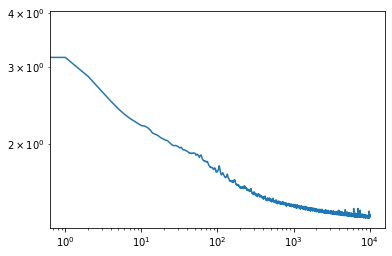

In [28]:
plt.loglog(history.history['loss'])

In [29]:
z = model.predict(X_train)

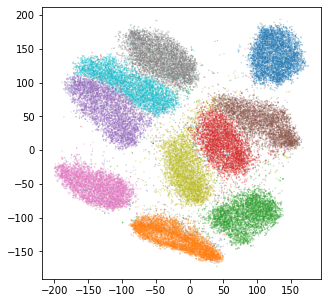

In [30]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=Y_train, cmap=plt.cm.tab10)